In [0]:
%matplotlib inline

In [0]:
!pip install -q Pillow==4.2.1

# Style transfer

In [0]:
from torch import *
import torch.nn.functional as F
import torch.optim
import torchvision.models as mds
from torchvision import transforms
from functools import partial

import numpy as np
import scipy.ndimage
from pathlib import Path
import matplotlib.pyplot as plt

import PIL
from PIL import Image, ImageStat
import cv2

import urllib.request

import time

from IPython.display import clear_output

### Images

In [0]:
cnt_img_url = "https://www.biography.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cg_face%2Cq_auto:good%2Cw_300/MTE5NTU2MzE2MjgwNDg5NDgz/martin-luther-king-jr-9365086-2-402.jpg"

# st_img_url = "https://static1.squarespace.com/static/59413d96e6f2e1c6837c7ecd/t/5b7232f31ae6cfe55027a722/1535309412013/VVRRR%C2%A0-+Manolo+April%2C+2018"
st_img_url = "https://assets.saatchiart.com/saatchi/690521/art/3856139/2926022-GMGIDARJ-6.jpg"

In [5]:
cnt_img_path = Path("cnt_img.jpg")
st_img_path = Path("st_img.jpg")

urllib.request.urlretrieve(cnt_img_url, cnt_img_path)
urllib.request.urlretrieve(st_img_url, st_img_path)

(PosixPath('st_img.jpg'), <http.client.HTTPMessage at 0x7fe066a50860>)

In [0]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

normalize = transforms.Compose([
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

denorm = transforms.Compose([ 
    transforms.Normalize(mean=[0., 0., 0.], std=1/imagenet_std),
    transforms.Normalize(mean=imagenet_mean*(-1), std=[1., 1., 1.]),
])

def show_img(img, normalized=False, figsize=(7, 7)):
    if len(img.size()) == 4: img = img[0]
    if not normalized: 
        img = torch.tensor(img)
        img = denorm(img)
        img.detach_().requires_grad_(False)
    x = np.clip(np.rollaxis(img.cpu().numpy(), 0, 3), 0, 1)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(x)
    
def get_opt_img(size):
    opt_img = np.random.uniform(0, 1, size=size[1:]).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8, 8, 1])
    opt_img = torch.FloatTensor(opt_img)
    opt_img = normalize(opt_img).unsqueeze(0)
    return opt_img

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


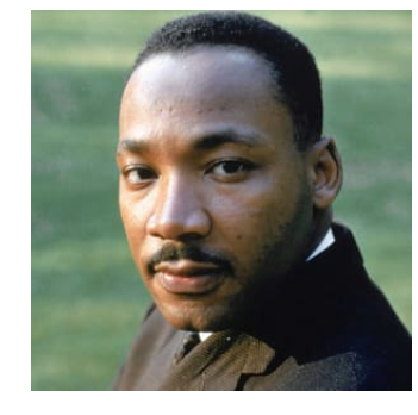

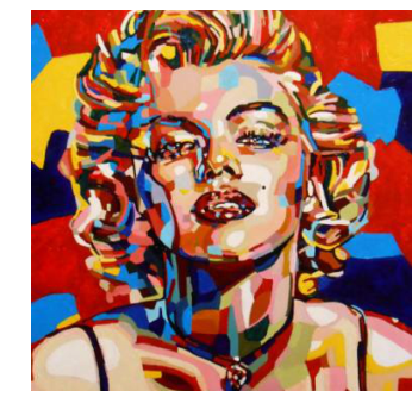

In [7]:
size = 320

raw_cnt_img = Image.open(cnt_img_path)
raw_st_img = Image.open(st_img_path)

cnt_tfms = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
cnt_img_v = cnt_tfms(raw_cnt_img).unsqueeze_(0)


st_tfms = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop((cnt_img_v.size()[2], cnt_img_v.size()[3])),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
st_img_v = st_tfms(raw_st_img).unsqueeze_(0)

if torch.cuda.is_available():
    cnt_img_v = cnt_img_v.cuda()
    st_img_v = st_img_v.cuda()

show_img(cnt_img_v)
show_img(st_img_v)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


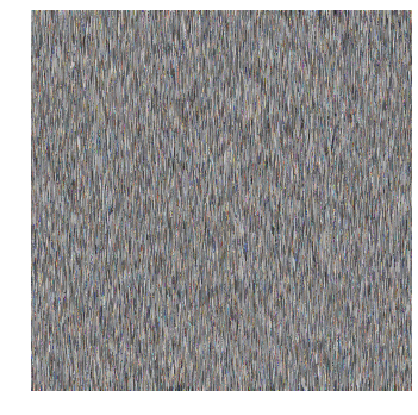

In [8]:
show_img(get_opt_img(cnt_img_v.shape))

### Model

In [0]:
vgg = mds.vgg16_bn(pretrained=True)

In [10]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [11]:
blocks = [i for i,l in enumerate(list(vgg.children())[0]) if isinstance(l, torch.nn.MaxPool2d)]
print(blocks)

[6, 13, 23, 33, 43]


In [0]:
del(vgg)

In [0]:
# blocks = [5, 12, 22, 32, 42]

In [0]:
class FeaturesHook():
    features = None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

### Gatys et al. method

In [0]:
vgg = list(mds.vgg16_bn(pretrained=True).children())[0]
if torch.cuda.is_available(): 
    vgg.cuda()
vgg = vgg.eval()
for c in vgg.parameters():
    c.requires_grad_(False)

In [0]:
opt_img_v = get_opt_img(cnt_img_v.shape)
if torch.cuda.is_available(): 
    opt_img_v = opt_img_v.cuda()
opt_img_v.requires_grad_(True)
opt = torch.optim.LBFGS([opt_img_v])

In [0]:
fs = [FeaturesHook(list(vgg.children())[idx]) for idx in blocks]

In [0]:
def gram(input):
    b, c, h, w = input.size()
    x = input.view(b*c, -1)
    return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [0]:
vgg(cnt_img_v)
targ_cnt = [o.features.clone() for o in fs]

In [0]:
vgg(st_img_v)
targ_st = [o.features.clone() for o in fs]

In [0]:
alpha = 1e7
def gatys_loss(x):
    vgg(x)
    outs = [out.features for out in fs]
    
    style_loss = sum([gram_mse_loss(o, s) for o,s in zip(outs, targ_st)])
    cnt_loss = F.mse_loss(outs[3], targ_cnt[3])*alpha
    
    return style_loss + cnt_loss

In [0]:
def closure():
    global n_iter, t1
    opt.zero_grad()
    loss = gatys_loss(opt_img_v)
    loss.backward()
    n_iter += 1
    if n_iter%show_iter == 0: 
        print(f'{100*n_iter//max_iter}% done, loss: {loss.item()}, time: {int(time.time()-t1)}s')
        t1 = time.time()
    return loss

10% done, loss: 71757.3984375, time: 12s
20% done, loss: 32730.509765625, time: 13s
30% done, loss: 23733.72265625, time: 13s
40% done, loss: 20331.03515625, time: 13s
50% done, loss: 18456.255859375, time: 13s
60% done, loss: 17188.09765625, time: 13s
70% done, loss: 16275.044921875, time: 13s
80% done, loss: 15573.982421875, time: 13s
90% done, loss: 14976.560546875, time: 13s
100% done, loss: 14456.4248046875, time: 13s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


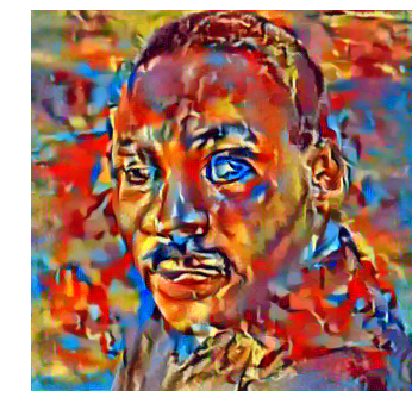

In [23]:
n_iter = 0
show_iter = 100
max_iter = 1000
g_iter = 0
t1 = time.time()
while n_iter <= max_iter:
    opt.step(closure)
show_img(opt_img_v)

In [0]:
for o in fs: o.remove()

### Li and Wand method
(incomplete)

In [0]:
vgg = list(mds.vgg16_bn(pretrained=True).children())[0]
if torch.cuda.is_available(): vgg.cuda()
vgg = vgg.eval()
for c in vgg.parameters():
    c.requires_grad_(False)

In [0]:
opt_img_v = get_opt_img(cnt_img_v.shape)
if torch.cuda.is_available(): opt_img_v = opt_img_v.cuda()
opt_img_v.requires_grad_(True)
opt = torch.optim.LBFGS([opt_img_v])

In [0]:
fs = [FeaturesHook(list(vgg.children())[idx]) for idx in blocks][2:4]

In [0]:
vgg(cnt_img_v)
targ_cnt = [o.features.clone() for o in fs]

In [0]:
vgg(st_img_v)
targ_st = [o.features.clone() for o in fs]

In [0]:
def get_patches(x, window=5):
    ch, w, h = x.shape
    y = np.zeros((ch, h+2, w+2))
    y[:, 1:h+1, 1:w+1] = x 
    
    ch, w, h = y.shape
    s2, s1, s0 = y.strides
    
    p = np.lib.stride_tricks.as_strided(y, shape = (w-window+1, h-window+1, ch, window, window), strides = (s1, s0, s2, s1, s0))
    p = p.reshape((w-window+1)*(h-window+1), -1)
    return p
# %time get_patches(targ_cnt[1].squeeze(0).cpu().numpy()).shape

In [0]:
def match_filters(cnt_filter, st_filter):
    res = []
    for cf, sf in zip(cnt_filter, st_filter):
        cf = torch.Tensor(get_patches(cf[0].detach().cpu().numpy()))
        if torch.cuda.is_available():
            cf.cuda()
        mm = torch.mm(cf, sf.t())
        cnt_norm = torch.sqrt((cf ** 2).sum(1))
        st_norm = torch.sqrt((sf ** 2).sum(1))
        cosine_sim = mm/(1e-15+st_norm.unsqueeze(1)*cnt_norm.unsqueeze(0))
        _, maxes = cosine_sim.max(1)
        res.append(maxes.cpu().numpy())
    return res

In [0]:
def mrf(targ_cnt, targ_st, st_patches):
    matches = match_filters(targ_cnt, st_patches)
    new_st = []
    for sf, mf in zip(targ_st, matches):
        sf = sf.view(sf.size(1), -1)
        sf = sf[:, mf]
        new_st.append(sf)
    return new_st

In [0]:
st_patches = [torch.Tensor(get_patches(st.squeeze(0).cpu().numpy())) for st in targ_st]
new_st = mrf(targ_cnt, targ_st, st_patches)

In [0]:
def gram(input):
    if(len(input.size()) == 4):
        b, c, h, w = input.size()
        x = input.view(b*c, -1)
    else:
        x = input
    return torch.mm(x, x.t())/input.numel()*1e3

def gram_mse_loss(input, target):
    return F.mse_loss(gram(input), gram(target))

In [0]:
g_iter = 0
alpha = 2e7
p = [torch.Tensor(get_patches(st.squeeze(0).cpu().numpy())) for st in targ_st]
if torch.cuda.is_available(): 
    for st in p: 
        st.cuda()
        
def li_wand_loss(x):
    global g_iter
    vgg(x)
    outs = [out.features for out in fs]
    
    style_loss = sum([gram_mse_loss(o, s) for o,s in zip(outs, new_st)])
#     style_loss = sum([gram_mse_loss(o, s) for o,s in zip(outs[:2], targ_st[:2])])
#     style_loss = sum(gram_mse_loss(o, s) for o, s in zip(outs, mrf(outs, targ_st, p)))
    cnt_loss = F.mse_loss(outs[-1], targ_cnt[-1])*alpha
    
    g_iter += 1
#     if g_iter%show_iter == 0: print(f"cnt_loss: {cnt_loss}\nst_loss: {style_loss}")
    return style_loss + cnt_loss

In [0]:
def closure():
    global n_iter, t1
    opt.zero_grad()
    loss = li_wand_loss(opt_img_v)
    loss.backward()
    n_iter += 1
    if n_iter%show_iter == 0: 
        print(f'{100*n_iter//max_iter}% done, loss: {loss.item()}, time: {int(time.time()-t1)}s')
        t1 = time.time()
    return loss

8% done, loss: 10053.25, time: 11s
16% done, loss: 5198.29638671875, time: 13s
25% done, loss: 3713.852783203125, time: 13s
33% done, loss: 2998.6826171875, time: 13s
41% done, loss: 2555.652099609375, time: 13s
50% done, loss: 2271.2744140625, time: 13s
58% done, loss: 2054.41455078125, time: 13s
66% done, loss: 1896.1370849609375, time: 13s
75% done, loss: 1770.2591552734375, time: 13s
83% done, loss: 1671.3082275390625, time: 13s
91% done, loss: 1592.560546875, time: 13s
100% done, loss: 1527.241943359375, time: 13s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


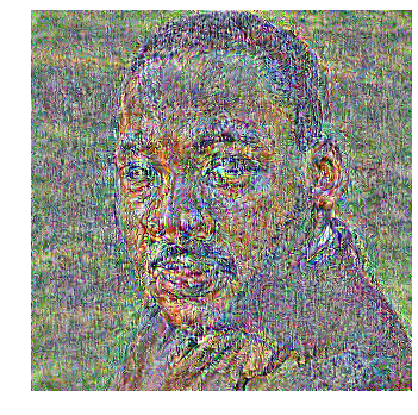

In [37]:
n_iter = 0
show_iter = 100
max_iter = 12*100
g_iter = 0
t1 = time.time()
while n_iter <= max_iter:
    opt.step(closure)
show_img(opt_img_v)

In [0]:
 for o in fs: o.remove()